## Webinar 12 Transfer Learning + Model Deployment (Jika Waktu Cukup)
- Intro
- Materi Sesi 1
- Istirahat
- Materi Sesi 2
- Closing

In [ ]:
!pip install transformers datasets evaluate
!pip install accelerate -U

# Transfer Learning

![](https://storage.googleapis.com/rg-ai-bootcamp/model_usage/transfer-learning.gif)

## Introduction

Do you need help to train complex models due to limited high-quality data and resources? 🤔 Don't panic! The answer is **Transfer Learning**. This technique leverages pre-trained models, like BERT for NLP or [ImageNet](https://www.image-net.org/) for image classification, to significantly reduce training time. Think of it as teaching an old dog new tricks: You can easily adapt an ImageNet model to tasks like dog breed classification. And voila! You've just made quick progress even with scarce data.

## How does Neural Network change in Transfer Learning?

Imagine a chef who is skilled in baking cakes. Suppose this chef needs to cook a new dish, like pasta. Instead of starting from scratch, they leverage their culinary skills, adjusting only where necessary for the pasta-specific nuances.

Similarly, two possible approaches exist in machine learning: "Training from Scratch" and "Transfer Learning". In the former, a model like CNN is trained on a new dataset, like Vehicles, without prior knowledge. In the latter, the model leverages prior knowledge acquired from a different dataset, like Animals, and adjusts this understanding to the new task.

![](https://miro.medium.com/v2/resize:fit:720/0*xNjEPIZmPvKeqss6)

- training from scratch --> 1 juta images --> membutuhkan waktu yang lama --> arsitektur NN
- transfer learning --> 100 images cats vs dogs -> resnet 50 --> hasilnya lebih cepat --> sisi akurasinya tidak terlalu jauh

The image above illustrates this concept. As shown, a model trained from scratch (the top one) is set up to learn directly from the vehicle dataset. It starts with no inherent understanding of images and must learn the features that differentiate one vehicle from another.

In contrast, a transfer learning model (the bottom) begins with a pre-trained network with pre-existing knowledge about different animals. This model is fine-tuned to distinguish different types of vehicles, typically achieving faster and more efficient results than training from scratch.

In essence, while both models aim to classify different types of vehicles, they learn differently: the model trained from scratch learns all features independently, like a chef learning a new dish from scratch, whereas the transfer learning model refines existing knowledge for the new task, similar to a chef adapting their existing skills to a new recipe.

## Hands-On with MNIST

Let's see transfer learning in action on the famous [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a large collection of handwritten numbers. We will use PyTorch, a powerful open source library for machine learning in Python, as we have done in previous PyTorch materials.

### Data Loader

First, we have to load the data and check it. But how can you load large data sets in manageable batches? PyTorch DataLoader makes this possible and efficient. This is especially useful when the data is large and cannot be loaded into memory.

In [ ]:
import torch

# Load MNIST data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load MNIST data
mnist_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Inspect data
print(mnist_train)
print(mnist_test)

# Use Data Loader
train_loader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

# Iterate through data
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


In [ ]:
1 * 28 * 28

784

### Visualizing the Data

Visualizing our data can help us understand it better. But what if you're not sure how to display images from your dataset? No worries! With matplotlib, a powerful plotting library in Python, we can easily visualize our images.

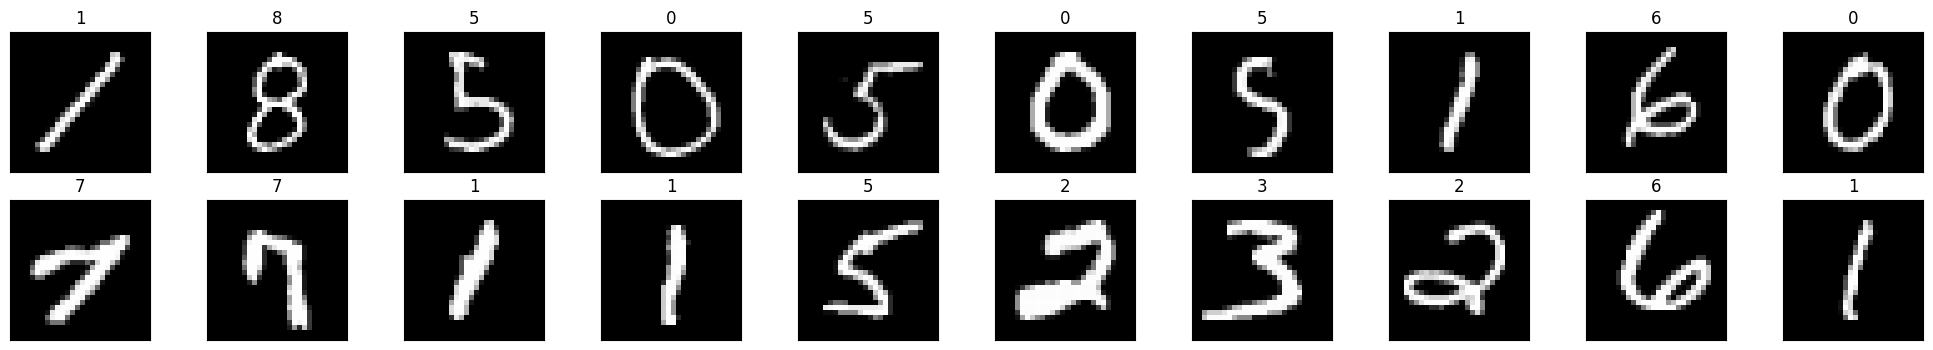

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define label mapping
classes = [str(i) for i in range(10)] # because MNIST has 10 classes from digit 0 to digit 9

# Load a batch of images
images, labels = next(iter(train_loader))

# Convert images to numpy for visualization
images = images.numpy()

# Convert images from 1 channel to 3 channels for visualization
images = np.repeat(images, 3, axis=1)

# Plot the images with their labels
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in range(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

OK, now let's start training with the model we created ourselves.

In [ ]:
import torch.nn as nn

# Define model
class CreateModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 100)
        self.hidden = nn.Linear(100, 10)

    def forward(self, xb):
        # Flatten the image tensors using reshape
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        out = self.hidden(out)
        return out

# Instantiate the model
model = CreateModel()

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Train
for epoch in range(3):
    for images, labels in train_loader:
        # Generate predictions
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        # Perform gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 20, loss.item()))

# Evaluate
with torch.no_grad():
    accum_acc = 0
    for images, labels in test_loader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        acc = accuracy(outputs, labels)
        accum_acc += acc

    print('Test loss: {:.4f}, Test accuracy: {:.4f}'.format(loss.item(), accum_acc/len(test_loader)))

### Making Individual Predictions

Building and training a model is great, but how do we make predictions on individual images? What if you're not sure how to use your newly trained model? The `predict_image` function provides a straightforward way to get your model's prediction for a single image.

Label: 5 , Predicted: 5


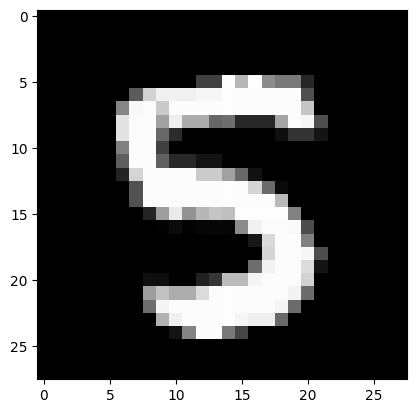

In [ ]:
import matplotlib.pyplot as plt

def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = mnist_test[120] # Explore the data with index
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


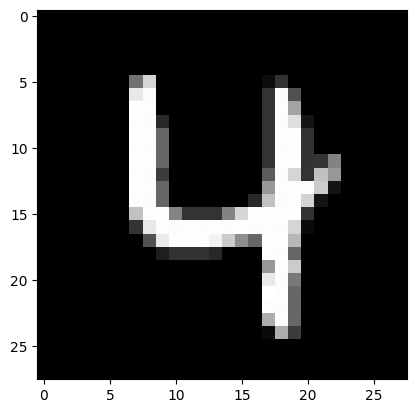

In [ ]:
img, label = mnist_test[49] # Explore the data with index
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

## Fine-tuning with FashionMNIST

Now, what if we want to classify different types of clothing, not just digits? Transfer learning to the rescue! We can fine-tune our pre-trained model on the new data to achieve great results.

That's where the [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist) comes in. It's a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

Sounds daunting? Don't worry! With transfer learning, we can leverage the experience our model gained from MNIST to tackle this new task.

### Data Loader

The first step, we have to load the FashionMNIST data as we do in MNIST.

In [ ]:
# Load FashionMNIST data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

fashion_train = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

# Inspect data
print(fashion_train)
print(fashion_test)

# Use Data Loader
fashion_train_loader = DataLoader(fashion_train, batch_size=100, shuffle=True)
fashion_test_loader = DataLoader(fashion_test, batch_size=100, shuffle=False)

# Iterate through data
for images, labels in fashion_train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


### Visualizing the FashionMNIST Data with Class Labels

Visualizing data is helpful, but wouldn't it be even better if we could visualize it with the corresponding class labels? What if you're not sure how to map the labels of your data to their actual class names? That's where the `classes` list comes into play.

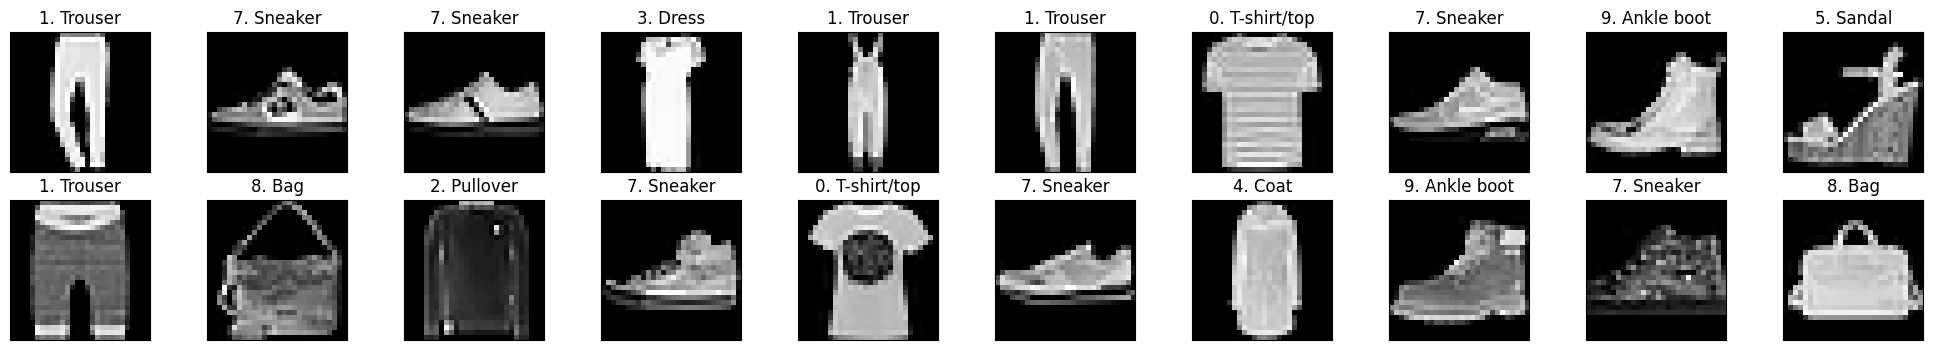

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define label mapping for FashionMNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

images, labels = next(iter(fashion_train_loader))
images = images.numpy()
images = np.repeat(images, 3, axis=1)
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in range(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(f"{labels[idx]}. {classes[labels[idx]]}")

## Testing the Model's Predictions on Unseen FashionMNIST Data

After training our model on the MNIST dataset, we might wonder how it would perform on the FashionMNIST dataset without any further training. What if we could use our model to make a prediction on a FashionMNIST image? By calling the `predict_image` function, we can do exactly that!

Label: 4 , Predicted: 2


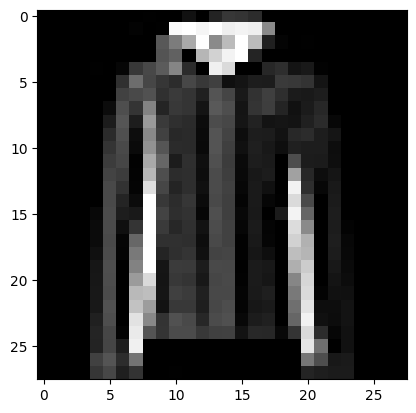

In [ ]:
import matplotlib.pyplot as plt

img, label = fashion_test[6] # Explore the data with index
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Unfortunately, without any further training, the model struggles to correctly classify images from the FashionMNIST dataset. This result may seem disappointing, but it is not entirely surprising. The MNIST and FashionMNIST datasets, despite sharing the same structure, represent completely different kinds of images (handwritten digits versus clothing items), and it's a tough ask for a model trained specifically on digits to accurately classify clothing items.

This is exactly where the power of transfer learning shines! Let's start training with the model architecture that we used for MNIST but this time, we'll fine-tune it on the FashionMNIST data. With this approach, our model can quickly learn to generalize from digits to clothing items, showcasing the strength of transfer learning in practice.

In [ ]:
# Fine-tuning with FashionMNIST data
for epoch in range(3):
    for images, labels in fashion_train_loader:
        # Generate predictions
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Perform gradient descent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 20, loss.item()))

# Evaluate with FashionMNIST test data
with torch.no_grad():
    accum_acc = 0
    for images, labels in fashion_test_loader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        acc = accuracy(outputs, labels)
        accum_acc += acc

    print('Test loss: {:.4f}, Test accuracy: {:.4f}'.format(loss.item(), accum_acc/len(fashion_test_loader)))

### Testing the Model's Predictions After Fine-Tuning

After fine-tuning our model on the FashionMNIST dataset, we need to verify if it improved the model's performance. What if we could test our model's prediction on a FashionMNIST image again, but this time after fine-tuning? That's precisely where the `predict_image` function comes in handy.

Label: 3. is: Dress, Predicted: 3. is: Dress


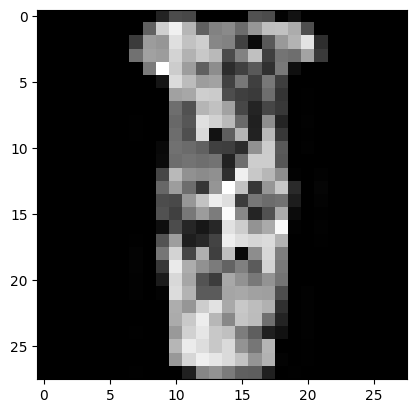

In [ ]:
import matplotlib.pyplot as plt

label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

img, label = fashion_test[100] # Explore the data with index
plt.imshow(img[0], cmap='gray')
print(f"Label: {label}. is: {label_map[label]}, Predicted: {predict_image(img, model)}. is: {label_map[predict_image(img, model)]}")

## Exploring Further Into Fine-Tuning and Use Cases

After testing our model on FashionMNIST data, we should now further deepen our understanding of fine-tuning. This sophisticated technique is not only limited to image classification tasks but can also be applied across various domains, including:

1. **Natural Language Processing (NLP)**
   - Text Classification
   - Summarization
   - And more
2. **Audio**
   - Audio classification
   - Automatic speech recognition
   - And more
3. **Computer Vision**
   - Image Classification
   - Object detection
   - And more
4. **Multimodal**
   - Image Captioning
   - Document Question Answering
   - And more

One such example is audio classification. By using a pre-trained model like Wav2Vec2 and fine-tuning it on a specific dataset, we can create a powerful audio classification model even with less training data. This process includes several steps such as loading the dataset, preprocessing the data, setting up an evaluation metric, and finally training and evaluating the model.

Let's see how we can apply fine-tuning to develop an audio classification model and test its performance!

### Audio Classification

Imagine you are a wildlife conservationist, you have a library of sounds, and you want to classify whether they come from one animal species or another. You struggle because there are so many audio files and analyzing them manually takes so much time and effort!

But don't worry! With the power of AI, we can make this process significantly easier and faster using a technique called **Audio Classification**.

[![](https://storage.googleapis.com/rg-ai-bootcamp/model_usage/audio-classification.png)](https://youtu.be/KWwzcmG98Ds)

Tasks: Audio Classification (source: [youtube.com](https://youtu.be/KWwzcmG98Ds))

Audio Classification can be used for various applications, including detecting speaker's intent, classifying languages, or in our case, identifying animal species by their sounds.

For this purpose, we are going to utilize the pre-trained [Wav2Vec2](https://huggingface.co/facebook/wav2vec2-base) model and fine-tune it on the [MInDS-14](https://huggingface.co/datasets/PolyAI/minds14) dataset specifically designed for this task. This approach reduces our training time and improves the model's performance even with less data!

Before we start, we need to make sure to have all the necessary Python libraries installed. Run this command in your Python environment:

In [ ]:
%pip install transformers datasets evaluate

We also encourage you to log in to your [Hugging Face account](https://huggingface.co/join) so you can upload and share your model with the community. If you are prompted, enter your token to login:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

**Load MInDS-14 dataset**

Now we are ready to load our dataset, MInDS-14, from the Datasets library:

In [ ]:
from datasets import load_dataset, Audio

minds = load_dataset("PolyAI/minds14", name="en-US", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

We will then split our dataset into a smaller training and testing set. This step allows us to experiment and validate our model before spending more time on the full dataset.

In [ ]:
minds = minds.train_test_split(test_size=0.2)

Then take a look at the dataset:

In [ ]:
minds

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 450
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 113
    })
})

While our dataset contains a lot of useful information, we will focus on the audio and intent_class in this guide. Let's remove the other columns:

In [ ]:
minds = minds.remove_columns(["path", "transcription", "english_transcription", "lang_id"])

In [ ]:
minds

DatasetDict({
    train: Dataset({
        features: ['audio', 'intent_class'],
        num_rows: 450
    })
    test: Dataset({
        features: ['audio', 'intent_class'],
        num_rows: 113
    })
})

Now let's take a look at an example in our dataset:

digit --> 1 x 28 x 28
fashion --> 1 x 28 x 28

In [ ]:
minds["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~CARD_ISSUES/602badcfbb1e6d0fbce92213.wav',
  'array': array([0.        , 0.        , 0.        , ..., 0.00024414, 0.00048828,
         0.00048828]),
  'sampling_rate': 8000},
 'intent_class': 6}

Great! Now we have our dataset loaded and ready. Its fields are:
- `audio`: a 1-dimensional array of the speech signal that we will use for training our model.
- `intent_class`: represents the class id of the speaker's intent (or in our case, the species of the animal).

To make it easier for the model to get the label name from the label id, we create a dictionary that maps the label name to an integer and vice versa:

In [ ]:
labels = minds["train"].features["intent_class"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

Now we can easily convert a label id to a label name:

In [ ]:
id2label[str(2)]

'app_error'

In [ ]:
id2label

{'0': 'abroad',
 '1': 'address',
 '2': 'app_error',
 '3': 'atm_limit',
 '4': 'balance',
 '5': 'business_loan',
 '6': 'card_issues',
 '7': 'cash_deposit',
 '8': 'direct_debit',
 '9': 'freeze',
 '10': 'high_value_payment',
 '11': 'joint_account',
 '12': 'latest_transactions',
 '13': 'pay_bill'}

In [ ]:
label2id

{'abroad': '0',
 'address': '1',
 'app_error': '2',
 'atm_limit': '3',
 'balance': '4',
 'business_loan': '5',
 'card_issues': '6',
 'cash_deposit': '7',
 'direct_debit': '8',
 'freeze': '9',
 'high_value_payment': '10',
 'joint_account': '11',
 'latest_transactions': '12',
 'pay_bill': '13'}

**Preprocess**

Now comes the interesting part: **Preprocessing**. In this step, we are going to load a Wav2Vec2 feature extractor to process the audio signal:

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


The MInDS-14 dataset has a sampling rate of 8000kHz, as found in its [dataset card](https://huggingface.co/datasets/PolyAI/minds14). The trained Wav2Vec2 model, however, requires the audio input to have a sampling rate of 16000kHz. Therefore, we must resample our dataset to convert the sampling rate from 8000kHz to 16000kHz to meet the model's requirements.

In [ ]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))
minds["train"][0]

{'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~CARD_ISSUES/602badcfbb1e6d0fbce92213.wav',
  'array': array([-1.58187468e-05, -2.77017243e-05,  1.62016368e-05, ...,
          5.89797681e-04,  4.69758408e-04,  2.24952935e-04]),
  'sampling_rate': 16000},
 'intent_class': 6}

We then create a preprocessing function to load and resample the audio file and ensure it matches the sampling rate of the model's pre-training data.

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

We use the Datasets map function to apply the preprocessing function across the complete dataset. Speed it up by enabling `batched=True` to process multiple dataset elements simultaneously. Remove unnecessary columns and rename `intent_class` to `label`, as the model expects this name.

Let's apply our preprocessing function across the complete dataset:

In [ ]:
encoded_minds = minds.map(preprocess_function, remove_columns="audio", batched=True)

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Map:   0%|          | 0/113 [00:00<?, ? examples/s]

After applying our preprocessing function, we rename our column name from `intent_class` to `label` because our model expects this name:

In [ ]:
encoded_minds = encoded_minds.rename_column("intent_class", "label")

In [ ]:
encoded_minds['train'][0]

**Setting up Evaluation Metric**

Now, how can we know if our model is performing well? We need a yardstick to measure it. That's when **Evaluation Metrics** come into play. We will use the `accuracy` metric from the `evaluate` library for this task.

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

Then, we create a function that will take our model's predictions and labels to calculate the accuracy:

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

Now, our `compute_metrics` function is ready to be used for training.

**Training and Evaluation**

We've come a long way! It's time to **Train and Evaluate** our model. We’re going to load the Wav2Vec2 model along with the number of expected labels, and the label mappings:

In [ ]:
from transformers import AutoModelForAudioClassification

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'classifier.weight', 'projector.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


During training, we will use an optimization strategy where we set a learning rate and batch size. We also set the `load_best_model_at_end=True` option which means our trainer will load the model with the highest accuracy at the end of the training:

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model/audio_classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,                  # learning rate
    per_device_train_batch_size=32,      # training batch size
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    load_best_model_at_end=True,         # model optimization via early stopping
    metric_for_best_model="accuracy",
    push_to_hub=True, # When set to True, this allows the trained model to be directly uploaded to the Hugging Face Model Hub.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_minds["train"],
    eval_dataset=encoded_minds["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.651145,0.070796
2,No log,2.652690,0.053097


TrainOutput(global_step=30, training_loss=2.6372024536132814, metrics={'train_runtime': 50.468, 'train_samples_per_second': 17.833, 'train_steps_per_second': 0.594, 'total_flos': 8171035833600000.0, 'train_loss': 2.6372024536132814, 'epoch': 2.0})

In [ ]:
8, 16, 32, 64, 128, 256, 512, 1024

Once training is completed, we can share our model to the Hugging Face Model Hub so that everyone can use our model:

In [ ]:
trainer.push_to_hub('model-test-v1')

'https://huggingface.co/Adipta/image_classification/tree/main/'

Here is an example of a model that has been trained: <https://huggingface.co/aditira/audio_classification>

**Inference**

Finally, let's test our model with a new audio file. This step is called **Inference**. We will load an audio file and run our model to classify it. Remember to resample the audio file to match the model's sampling rate!

In [ ]:
from datasets import load_dataset, Audio
from transformers import pipeline

dataset = load_dataset("PolyAI/minds14", name="en-US", split="train")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
sampling_rate = dataset.features["audio"].sampling_rate
audio_file = dataset[0]["audio"]["path"]

classifier = pipeline("audio-classification", model="model/audio_classification")
classifier(audio_file)

[{'score': 0.07988371700048447, 'label': 'balance'},
 {'score': 0.07584269344806671, 'label': 'joint_account'},
 {'score': 0.07483551651239395, 'label': 'address'},
 {'score': 0.07401867210865021, 'label': 'card_issues'},
 {'score': 0.07396950572729111, 'label': 'high_value_payment'}]

In [ ]:
dataset[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-US~JOINT_ACCOUNT/602ba55abb1e6d0fbce92065.wav',
  'array': array([ 1.70562416e-05,  2.18727451e-04,  2.28099874e-04, ...,
          3.43842403e-05, -5.96364771e-06, -1.76846661e-05]),
  'sampling_rate': 16000},
 'transcription': 'I would like to set up a joint account with my partner',
 'english_transcription': 'I would like to set up a joint account with my partner',
 'intent_class': 11,
 'lang_id': 4}

In [ ]:
id2label

{'0': 'abroad',
 '1': 'address',
 '2': 'app_error',
 '3': 'atm_limit',
 '4': 'balance',
 '5': 'business_loan',
 '6': 'card_issues',
 '7': 'cash_deposit',
 '8': 'direct_debit',
 '9': 'freeze',
 '10': 'high_value_payment',
 '11': 'joint_account',
 '12': 'latest_transactions',
 '13': 'pay_bill'}

Congratulations! You just classified an audio file using your fine-tuned model! Now, you can classify your entire library of animal sounds and make your work as a wildlife conservationist a bit easier.

### Image classification

Imagine you've just been hired as a data scientist at a health-focused tech startup. You're tasked with developing a system that identifies food items from images uploaded by users. The goal is to enable users to track their nutrition intake simply by taking a picture. But how would you go about this?

Well, the good news is, with the advent of **Image Classification** in machine learning, this task is no longer a pipe dream, but a very achievable reality.

[![](https://storage.googleapis.com/rg-ai-bootcamp/model_usage/image-classification.png)](https://youtu.be/tjAIM7BOYhw)

Tasks: Image Classification (source: [youtube.com](https://youtu.be/tjAIM7BOYhw))

Image classification can be used in countless applications, ranging from detecting objects in satellite images to medical imaging. In our case, we aim to classify food items from given images. We will use a pre-trained model called the Vision Transformer, or [ViT](https://huggingface.co/docs/transformers/v4.31.0/en/tasks/model_doc/vit) for short. ViT is a model that applies the transformer architecture, which was initially built for text data, to image data. We will fine-tune this model on the [Food-101](https://huggingface.co/datasets/food101) dataset to classify images into 101 food categories.

**Load Food-101 dataset**

Let's start with **Loading our Food-101 dataset**. We will load only a small subset of it to ensure everything works before committing to training on the full dataset:

In [ ]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

In [ ]:
beans = load_dataset("beans", split="train")

In [ ]:
beans

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})

We then split our dataset into a training set and a testing set:

In [ ]:
beans = beans.train_test_split(test_size=0.2)

In [ ]:
beans

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

Let's take a look at an example from our dataset:

In [ ]:
beans["train"][0]

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/angular_leaf_spot/angular_leaf_spot_train.10.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

Each example in the dataset has two fields:
- `image`: a PIL image of the food item
- `label`: the label class of the food item

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:


In [ ]:
food = beans

In [ ]:
labels = food["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
label2id

{'angular_leaf_spot': '0', 'bean_rust': '1', 'healthy': '2'}

In [ ]:
id2label

{'0': 'angular_leaf_spot', '1': 'bean_rust', '2': 'healthy'}

Now we can easily convert a label id to a label name:

In [ ]:
id2label[str(79)]

**Preprocess**

The next step is **Preprocessing**. Here we load a ViT image processor to process the image into a tensor:

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

To make our model robust against overfitting, we apply some image transformations to the images. Here we are using torchvision’s transforms module, but you can also use any image library you like. We crop a random part of the image, resize it, and normalize it with the image mean and standard deviation:

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Then we create a preprocessing function to apply the transforms and return the pixel_values - the inputs to the model - of the image:

In [ ]:
beans["train"][100]

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.175.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

In [ ]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

To apply the preprocessing function over the entire dataset, use Datasets with_transform method. The transforms are applied on the fly when you load an element of the dataset:

In [ ]:
food = food.with_transform(transforms)

In [ ]:
food

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

Next, we create a batch of examples using DefaultDataCollator. Unlike other data collators, the DefaultDataCollator does not apply additional preprocessing such as padding.

In [ ]:
pad - truncation
512 max token
100 token
1000 token

padding
- 100 token --> 512 token --> attention_mask (5,2,1,2,3,4,0,0,0,0,0,0,0,0)

truncation
- 1000 token --> 512 token

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

**Setting up Evaluation Metric**

Including a metric during training is beneficial for evaluating your model’s performance. We can load an evaluation method with the Evaluate library:

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

Now, we'll create a function that will take our model's predictions and labels to calculate the accuracy:

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Our `compute_metrics` function is ready now, and we'll use it when we set up our training.

**Training and Evaluation**

It's time to **Train and Evaluate** our model. We're going to load ViT with `AutoModelForImageClassification`. We'll specify the number of labels along with the number of expected labels, and the label mappings:

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


At this point, we'll set our training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/v4.31.0/en/main_classes/trainer#transformers.TrainingArguments). We'll make sure to set `remove_unused_columns=False` to keep the image column, which is crucial for creating `pixel_values`. We'll specify `output_dir` to save your model and enable `push_to_hub` to upload to Hugging Face. The Trainer will evaluate the accuracy and save a checkpoint after each epoch:


In [ ]:
food

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model/image_classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,                 # learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,        # model optimization via early stopping
    metric_for_best_model="accuracy",
    push_to_hub=True, # When set to True, this allows the trained model to be directly uploaded to the Hugging Face Model Hub.
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.288482,0.917874
2,No log,0.182862,0.946860
3,No log,0.178906,0.956522


TrainOutput(global_step=156, training_loss=0.30532144888853413, metrics={'train_runtime': 124.4488, 'train_samples_per_second': 19.936, 'train_steps_per_second': 1.254, 'total_flos': 1.922593493780951e+17, 'train_loss': 0.30532144888853413, 'epoch': 3.0})

**Evaluating the Trained Model**

After the training is completed, we need to evaluate the model. We'll use the accuracy metric from the `evaluate` library to assess the model's performance.

In [ ]:
eval_result = trainer.evaluate(eval_dataset=food["test"])
print(eval_result)

{'eval_loss': 0.1728488653898239, 'eval_accuracy': 0.9420289855072463, 'eval_runtime': 3.7355, 'eval_samples_per_second': 55.415, 'eval_steps_per_second': 3.48, 'epoch': 3.0}


The evaluation results will give us the accuracy of the test set. If this accuracy is satisfactory, we could decide to publish the model. If not, we might need to revisit the preprocessing, model architecture, or training process (e.g., tuning hyperparameters and increasing the number of epochs).

Once the training is completed, we can share our model to Hugging Face Model Hub so the model can be accessed by anyone:

In [ ]:
trainer.push_to_hub()

'https://huggingface.co/Adipta/image_classification/tree/main/'

Here is an example of a model that has been trained: <https://huggingface.co/aditira/image_classification>

**Inference**

With the model trained, we can now make use of it for **Inference**. Let's load an image we'd like to run inference on:

In [ ]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

The simplest way to try out our fine-tuned model for inference is to use it in a pipeline(). Instantiate a pipeline for image classification with our model, and pass our image to it:

In [ ]:
food

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="Adipta/image_classification")
classifier(beans["train"][0]['image'])

[{'score': 0.8206990361213684, 'label': 'bean_rust'},
 {'score': 0.12174737453460693, 'label': 'angular_leaf_spot'},
 {'score': 0.05755360424518585, 'label': 'healthy'}]

In [ ]:
id2label

{'0': 'angular_leaf_spot', '1': 'bean_rust', '2': 'healthy'}

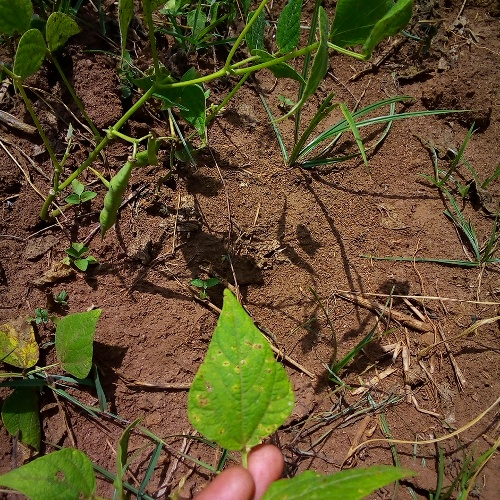

In [ ]:
beans["train"][0]['image']


Congratulations! You've managed to classify a food item from an image, bringing our startup's vision one step closer to reality. Now you can continue to refine and apply this model, making nutrition tracking easier and more accessible for users around the world.

## Conclusion: The Power of Fine-Tuning and the Right Choice of Pre-trained Models

Think of learning as building a house. Starting from scratch, you'd need to lay down the foundation, put up the walls, install the plumbing and wiring, and then finally add the finishing touches like paint and furniture.

![building a house](https://kutaisitoday.com/wp-content/uploads/2021/07/ilustrasi-membangun-rumah.jpg)

Building a House _(source: [kutaisitoday.com](https://kutaisitoday.com/4-keuntungan-memakai-jasa-desain-rumah/))_

Similarly, training a model from scratch requires learning all the features and architectures, often requiring a large amount of data and computational resources, which is not always feasible.

Now, what if you could start with a house that's already built and just rearrange the furniture and repaint the walls to suit your taste? This is the idea behind **transfer learning** or **fine-tuning**. We start with a model that has already learned useful features from a large-scale dataset (the pre-built house), and then fine-tune it on our specific task (rearranging and repainting).

In our case, the 'house' is the Vision Transformer (ViT), pre-trained on the ImageNet dataset. It's a robust and versatile model, well-suited for various image classification tasks. But it's not specialized in identifying food items.

So, we give it a makeover. We fine-tune the ViT on our Food-101 dataset. The model keeps its acquired knowledge and tailors it to our specific purpose - classifying food images. It's like hiring an interior designer (the fine-tuning process) to transform a generic house (the pre-trained ViT) into a gourmet restaurant (the food-classification model).

But why ViT? Why not another model? 🤔

The choice of a pre-trained model is crucial. It should ideally have an architecture that's well-suited to your task and has been trained on a large, diverse dataset. ViT is a good choice because it brings the power of transformers, which can capture complex dependencies in data, into the realm of vision. It's been pre-trained on ImageNet, a large-scale, diverse dataset, allowing it to learn a wide variety of features.

Yet it's important to remember that there is no one-size-fits-all model. The choice would depend on your task, data, and computational resources.